![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/10.Clinical_Relation_Extraction.ipynb)

# Clinical Relation Extraction Model

## Colab Setup

In [1]:
import json

with open('workshop_license_keys_365.json') as f:
    license_keys = json.load(f)

license_keys.keys()


dict_keys(['PUBLIC_VERSION', 'JSL_VERSION', 'SECRET', 'SPARK_NLP_LICENSE', 'AWS_ACCESS_KEY_ID', 'AWS_SECRET_ACCESS_KEY', 'SPARK_OCR_LICENSE', 'SPARK_OCR_SECRET'])

In [ ]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

secret = license_keys['SECRET']

os.environ['SPARK_NLP_LICENSE'] = license_keys['SPARK_NLP_LICENSE']
os.environ['AWS_ACCESS_KEY_ID']= license_keys['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY'] = license_keys['AWS_SECRET_ACCESS_KEY']
version = license_keys['PUBLIC_VERSION']
jsl_version = license_keys['JSL_VERSION']

! pip install --ignore-installed -q pyspark==2.4.4

! python -m pip install --upgrade spark-nlp-jsl==$jsl_version  --extra-index-url https://pypi.johnsnowlabs.com/$secret

! pip install --ignore-installed -q spark-nlp==$version

import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
import sparknlp_jsl

spark = sparknlp_jsl.start(secret)

## 1. Posology Releation Extraction

This is a demonstration of using SparkNLP for extracting posology relations. The following relatios are supported:

DRUG-DOSAGE
DRUG-FREQUENCY
DRUG-ADE (Adversed Drug Events)
DRUG-FORM
DRUG-ROUTE
DRUG-DURATION
DRUG-REASON
DRUG=STRENGTH

The model has been validated agains the posology dataset described in (Magge, Scotch, & Gonzalez-Hernandez, 2018).

| Relation | Recall | Precision | F1 | F1 (Magge, Scotch, & Gonzalez-Hernandez, 2018) |
| --- | --- | --- | --- | --- |
| DRUG-ADE | 0.66 | 1.00 | **0.80** | 0.76 |
| DRUG-DOSAGE | 0.89 | 1.00 | **0.94** | 0.91 |
| DRUG-DURATION | 0.75 | 1.00 | **0.85** | 0.92 |
| DRUG-FORM | 0.88 | 1.00 | **0.94** | 0.95* |
| DRUG-FREQUENCY | 0.79 | 1.00 | **0.88** | 0.90 |
| DRUG-REASON | 0.60 | 1.00 | **0.75** | 0.70 |
| DRUG-ROUTE | 0.79 | 1.00 | **0.88** | 0.95* |
| DRUG-STRENGTH | 0.95 | 1.00 | **0.98** | 0.97 |


*Magge, Scotch, Gonzalez-Hernandez (2018) collapsed DRUG-FORM and DRUG-ROUTE into a single relation.

In [ ]:
import os
import re
import pyspark
import sparknlp
import sparknlp_jsl
import functools 
import json

import numpy as np
from scipy import spatial
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from sparknlp_jsl.annotator import *
from sparknlp.annotator import *
from sparknlp.base import *


**Build pipeline using SparNLP pretrained models and the relation extration model optimized for posology**.
 
 The precision of the RE model is controlled by "setMaxSyntacticDistance(4)", which sets the maximum syntactic distance between named entities to 4. A larger value will improve recall at the expense at lower precision. A value of 4 leads to literally perfect precision (i.e. the model doesn't produce any false positives) and reasonably good recall.

In [3]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

tokenizer = sparknlp.annotators.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")

ner_tagger = NerDLModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

ner_event = NerDLModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags") 

ner_chunker = NerConverter()\
    .setInputCols(["sentences", "tokens", "ner_tags"])\
    .setOutputCol("ner_chunks")

dependency_parser = DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

reModel = RelationExtractionModel()\
    .pretrained("posology_re")\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)

pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_chunker,
    dependency_parser,
    reModel
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_data)



embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.7 MB
[OK!]
ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
ner_events_clinical download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.6 MB
[OK!]


**Create empty dataframe**

In [ ]:
empty_data = spark.createDataFrame([[""]]).toDF("text")


**Create a light pipeline for annotating free text**

In [ ]:
model = pipeline.fit(empty_data)
lmodel = sparknlp.base.LightPipeline(model)

In [ ]:
text = """
The patient was prescribed 1 unit of Advil for 5 days after meals. The patient was also 
given 1 unit of Metformin daily.
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 
12 units of insulin lispro with meals , and metformin 1000 mg two times a day.
"""
results = lmodel.fullAnnotate(text)

In [ ]:
results[0]['ner_chunks']

[Annotation(chunk, 28, 33, 1 unit, {'entity': 'DOSAGE', 'sentence': '0', 'chunk': '0'}),
 Annotation(chunk, 38, 42, Advil, {'entity': 'DRUG', 'sentence': '0', 'chunk': '1'}),
 Annotation(chunk, 44, 53, for 5 days, {'entity': 'DURATION', 'sentence': '0', 'chunk': '2'}),
 Annotation(chunk, 96, 101, 1 unit, {'entity': 'DOSAGE', 'sentence': '1', 'chunk': '3'}),
 Annotation(chunk, 106, 114, Metformin, {'entity': 'DRUG', 'sentence': '1', 'chunk': '4'}),
 Annotation(chunk, 116, 120, daily, {'entity': 'FREQUENCY', 'sentence': '1', 'chunk': '5'}),
 Annotation(chunk, 190, 197, 40 units, {'entity': 'DOSAGE', 'sentence': '2', 'chunk': '6'}),
 Annotation(chunk, 202, 217, insulin glargine, {'entity': 'DRUG', 'sentence': '2', 'chunk': '7'}),
 Annotation(chunk, 219, 226, at night, {'entity': 'FREQUENCY', 'sentence': '2', 'chunk': '8'}),
 Annotation(chunk, 231, 238, 12 units, {'entity': 'DOSAGE', 'sentence': '2', 'chunk': '9'}),
 Annotation(chunk, 243, 256, insulin lispro, {'entity': 'DRUG', 'sentence'

**Sample free text**

In [ ]:
text = """
The patient was prescribed 1 unit of Advil for 5 days after meals. The patient was also 
given 1 unit of Metformin daily.
He was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 
12 units of insulin lispro with meals , and metformin 1000 mg two times a day.
"""
results = lmodel.fullAnnotate(text)

**Show extracted relations**

In [ ]:
for rel in results[0]["relations"]:
    print("{}({}={} - {}={})".format(
        rel.result, 
        rel.metadata['entity1'], 
        rel.metadata['chunk1'], 
        rel.metadata['entity2'],
        rel.metadata['chunk2']
    ))

DOSAGE-DRUG(DOSAGE=1 unit - DRUG=Advil)
DRUG-DURATION(DRUG=Advil - DURATION=for 5 days)
DOSAGE-DRUG(DOSAGE=1 unit - DRUG=Metformin)
DRUG-FREQUENCY(DRUG=Metformin - FREQUENCY=daily)
DOSAGE-DRUG(DOSAGE=40 units - DRUG=insulin glargine)
DRUG-FREQUENCY(DRUG=insulin glargine - FREQUENCY=at night)
DOSAGE-DRUG(DOSAGE=12 units - DRUG=insulin lispro)
DRUG-FREQUENCY(DRUG=insulin lispro - FREQUENCY=with meals)
DRUG-STRENGTH(DRUG=metformin - STRENGTH=1000 mg)
DRUG-FREQUENCY(DRUG=metformin - FREQUENCY=two times a day)


In [ ]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df


rel_df = get_relations_df (results)

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DOSAGE-DRUG,DOSAGE,28,33,1 unit,DRUG,38,42,Advil,1.0
1,DRUG-DURATION,DRUG,38,42,Advil,DURATION,44,53,for 5 days,1.0
2,DOSAGE-DRUG,DOSAGE,96,101,1 unit,DRUG,106,114,Metformin,1.0
3,DRUG-FREQUENCY,DRUG,106,114,Metformin,FREQUENCY,116,120,daily,1.0
4,DOSAGE-DRUG,DOSAGE,190,197,40 units,DRUG,202,217,insulin glargine,1.0
5,DRUG-FREQUENCY,DRUG,202,217,insulin glargine,FREQUENCY,219,226,at night,1.0
6,DOSAGE-DRUG,DOSAGE,231,238,12 units,DRUG,243,256,insulin lispro,1.0
7,DRUG-FREQUENCY,DRUG,243,256,insulin lispro,FREQUENCY,258,267,with meals,1.0
8,DRUG-STRENGTH,DRUG,275,283,metformin,STRENGTH,285,291,1000 mg,1.0
9,DRUG-FREQUENCY,DRUG,275,283,metformin,FREQUENCY,293,307,two times a day,1.0


In [ ]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

annotations = lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df



,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DURATION-DRUG,DURATION,493,500,five-day,DRUG,512,522,amoxicillin,1.0
1,DRUG-DURATION,DRUG,681,693,dapagliflozin,DURATION,695,708,for six months,1.0
2,DRUG-ROUTE,DRUG,1940,1946,insulin,ROUTE,1948,1951,drip,1.0
3,DOSAGE-DRUG,DOSAGE,2255,2262,40 units,DRUG,2267,2282,insulin glargine,1.0
4,DRUG-FREQUENCY,DRUG,2267,2282,insulin glargine,FREQUENCY,2284,2291,at night,1.0
5,DOSAGE-DRUG,DOSAGE,2295,2302,12 units,DRUG,2307,2320,insulin lispro,1.0
6,DRUG-FREQUENCY,DRUG,2307,2320,insulin lispro,FREQUENCY,2322,2331,with meals,1.0
7,DRUG-STRENGTH,DRUG,2339,2347,metformin,STRENGTH,2349,2355,1000 mg,1.0
8,DRUG-FREQUENCY,DRUG,2339,2347,metformin,FREQUENCY,2357,2371,two times a day,1.0


## 2. Clinical RE

**The set of relations defined in the 2010 i2b2 relation challenge**

TrIP: A certain treatment has improved or cured a medical problem (eg, ‘infection resolved with antibiotic course’)

TrWP: A patient's medical problem has deteriorated or worsened because of or in spite of a treatment being administered (eg, ‘the tumor was growing despite the drain’)

TrCP: A treatment caused a medical problem (eg, ‘penicillin causes a rash’)

TrAP: A treatment administered for a medical problem (eg, ‘Dexamphetamine for narcolepsy’)

TrNAP: The administration of a treatment was avoided because of a medical problem (eg, ‘Ralafen which is contra-indicated because of ulcers’)

TeRP: A test has revealed some medical problem (eg, ‘an echocardiogram revealed a pericardial effusion’)

TeCP: A test was performed to investigate a medical problem (eg, ‘chest x-ray done to rule out pneumonia’)

PIP: Two problems are related to each other (eg, ‘Azotemia presumed secondary to sepsis’)

In [ ]:
clinical_ner_tagger = sparknlp.annotators.NerDLModel()\
    .pretrained("ner_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setRelationPairs(["problem-test", "problem-treatment"]) # we can set the possible relation pairs (if not set, all the relations will be calculated)

loaded_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])

ner_clinical download started this may take some time.
Approximate size to download 13.8 MB
[OK!]
re_clinical download started this may take some time.
Approximate size to download 6 MB
[OK!]


In [ ]:
loaded_model = loaded_pipeline.fit(empty_data)
loaded_lmodel = LightPipeline(loaded_model)

In [ ]:
text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

annotations = loaded_lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.relation!="O"]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
6,TrAP,PROBLEM,617,620,T2DM,TREATMENT,626,637,atorvastatin,0.99955326
13,TrWP,TEST,1246,1258,blood samples,PROBLEM,1283,1301,significant lipemia,0.99998724
17,TeRP,TEST,1535,1547,the anion gap,PROBLEM,1553,1566,still elevated,0.9965193
23,TrAP,TEST,1838,1845,analysis,PROBLEM,1854,1880,interference from turbidity,0.9676019
27,TrWP,TREATMENT,1937,1951,an insulin drip,PROBLEM,1976,2003,a reduction in the anion gap,0.94099987
30,TeRP,PROBLEM,1976,2003,a reduction in the anion gap,TEST,2015,2027,triglycerides,0.9956793
31,TeRP,PROBLEM,2107,2137,her respiratory tract infection,TREATMENT,2157,2171,SGLT2 inhibitor,0.997498


## 3. Clinical Temporal Events RE

Temporal relations, or temporal links (denoted by the TLINK tag), indicate whether and how two EVENTs, two TIME, or an EVENT and a TIME related to each other in the clinical timeline. There are 3 type of relations here and below are some examples of Relations, with square brackets indicating EVENT and TIME connected by a temporal link:

**`BEFORE`**

The patient was given stress dose steroids prior to his surgery. ([stress dose steroids] `BEFORE` [his surgery])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `BEFORE` [admission])

His nasogastric tube was discontinued on 05-26-98. ([His nasogastric] `BEFORE` [05-26-98])

**`AFTER`**

Before admission, he had another serious concussion. ([admission] `AFTER` [another serious concussion])

On postoperative day No 1, he was started on Percocet. ([Percocet] `AFTER` [postoperative day No 1])


**`OVERLAP`**

She denies any fevers or chills. ([fevers] `OVERLAP` [chills])

The patient's serum creatinine on discharge date, 2012-05-06, was 1.9. ([discharge date] `OVERLAP` [2012-05-06])

His preoperative workup was completed and included a normal white count ([a normal white count] `OVERLAP` [His preoperative workup])

The patient had an undocumented history of possible atrial fibrillation prior to admission. ([possible atrial fibrillation] `OVERLAP` [admission])


| Relation | Recall | Precision | F1 |
| --- | --- | --- | --- |
| OVERLAP | 0.81 | 0.73 | **0.77** |
| BEFORE | 0.85 | 0.88 | **0.86** |
| AFTER | 0.38 | 0.46 | **0.69** |



This RE model works with `ner_events_clinical` NER model and expect the following entities as inputs:

[`OCCURRENCE`,
 `DATE`,
 `DURATION`,
 `EVIDENTIAL`,
 `TEST`,
 `PROBLEM`,
 `TREATMENT`,
 `CLINICAL_DEPT`,
 `FREQUENCY`,
 `TIME`]

In [ ]:

events_ner_tagger = sparknlp.annotators.NerDLModel()\
    .pretrained("ner_events_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

clinical_re_Model = RelationExtractionModel()\
    .pretrained("re_temporal_events_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setMaxSyntacticDistance(4)\
    .setPredictionThreshold(0.9)

loaded_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    events_ner_tagger,
    ner_chunker,
    dependency_parser,
    clinical_re_Model
])

ner_events_clinical download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
re_temporal_events_clinical download started this may take some time.
Approximate size to download 5.9 MB
[OK!]


In [ ]:
events_ner_tagger.getClasses()

['O',
 'B-OCCURRENCE',
 'B-DATE',
 'B-PROBLEM',
 'I-PROBLEM',
 'B-DURATION',
 'I-DURATION',
 'B-EVIDENTIAL',
 'I-OCCURRENCE',
 'B-TREATMENT',
 'I-TREATMENT',
 'I-DATE',
 'B-TEST',
 'I-TEST',
 'B-CLINICAL_DEPT',
 'I-CLINICAL_DEPT',
 'B-FREQUENCY',
 'I-FREQUENCY',
 'I-EVIDENTIAL',
 'B-TIME',
 'I-TIME']

In [ ]:
loaded_model = loaded_pipeline.fit(empty_data)
loaded_lmodel = LightPipeline(loaded_model)

In [ ]:
text ="She is diagnosed as cancer in 1991. Then she was admitted to Mayo Clinic in May 2000 and discharged in October 2001"

annotations = loaded_lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,BEFORE,PROBLEM,20,25,cancer,DATE,30,33,1991,0.9989215
1,AFTER,OCCURRENCE,49,56,admitted,CLINICAL_DEPT,61,71,Mayo Clinic,1.0
2,OVERLAP,OCCURRENCE,49,56,admitted,DATE,76,83,May 2000,0.99152386
3,BEFORE,CLINICAL_DEPT,61,71,Mayo Clinic,OCCURRENCE,89,98,discharged,1.0
4,BEFORE,OCCURRENCE,89,98,discharged,DATE,103,114,October 2001,0.95415086


In [ ]:
text ="On 9–28-92, the patient will return for chemotherapy and she will follow up with her primary doctor, for PT and Coumadin dosing on Monday."

annotations = loaded_lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df = rel_df[(rel_df.relation!="O")]

rel_df[(rel_df.relation!="O")&(rel_df.entity1!=rel_df.entity2)]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,OVERLAP,DATE,3,9,9–28-92,TREATMENT,40,51,chemotherapy,1.000000
1,OVERLAP,DATE,3,9,9–28-92,TREATMENT,105,106,PT,0.989851
3,OVERLAP,OCCURRENCE,66,74,follow up,CLINICAL_DEPT,81,98,her primary doctor,0.998086
4,OVERLAP,OCCURRENCE,66,74,follow up,TREATMENT,105,106,PT,0.999761
5,OVERLAP,OCCURRENCE,66,74,follow up,TREATMENT,112,126,Coumadin dosing,0.958726
6,OVERLAP,CLINICAL_DEPT,81,98,her primary doctor,TREATMENT,105,106,PT,1.000000
7,OVERLAP,CLINICAL_DEPT,81,98,her primary doctor,DATE,131,136,Monday,0.984193
9,AFTER,TREATMENT,105,106,PT,DATE,131,136,Monday,0.926052
10,OVERLAP,TREATMENT,112,126,Coumadin dosing,DATE,131,136,Monday,0.999999


In [ ]:
text ="""She is admitted to The John Hopkins Hospital 2 days ago with a history of gestational diabetes mellitus diagnosed.  
She was seen by the endocrinology service and she was discharged on 03/02/2018 on 40 units of insulin glargine, 
12 units of insulin lispro, and metformin 1000 mg two times a day. She had close follow-up with endocrinology post discharge. 
"""

annotations = loaded_lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df.confidence = rel_df.confidence.astype(float)

rel_df[(rel_df.relation!="O")]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,AFTER,OCCURRENCE,7,14,admitted,CLINICAL_DEPT,19,43,The John Hopkins Hospital,0.991467
1,BEFORE,OCCURRENCE,7,14,admitted,PROBLEM,74,102,gestational diabetes mellitus,0.999989
2,OVERLAP,CLINICAL_DEPT,19,43,The John Hopkins Hospital,DATE,45,54,2 days ago,0.999306
3,BEFORE,CLINICAL_DEPT,19,43,The John Hopkins Hospital,PROBLEM,74,102,gestational diabetes mellitus,0.996808
4,OVERLAP,CLINICAL_DEPT,133,157,the endocrinology service,DATE,185,194,03/02/2018,0.999964
5,OVERLAP,OCCURRENCE,171,180,discharged,DATE,185,194,03/02/2018,1.000000
6,AFTER,OCCURRENCE,171,180,discharged,TREATMENT,211,226,insulin glargine,0.999233
7,AFTER,OCCURRENCE,171,180,discharged,TREATMENT,242,255,insulin lispro,0.997469
8,OVERLAP,DATE,185,194,03/02/2018,TREATMENT,211,226,insulin glargine,0.999975
9,OVERLAP,DATE,185,194,03/02/2018,TREATMENT,242,255,insulin lispro,0.999682


## 3. Human Phenotype - Gene RE

https://github.com/lasigeBioTM/PGR

Human phenotype-gene relations are fundamental to fully understand the origin of some phenotypic abnormalities and their associated diseases. Biomedical literature is the most comprehensive source of these relations, however, we need Relation Extraction tools to automatically recognize them. We present the Phenotype-Gene Relations (PGR) model, trained on a silver standard corpus of human phenotype and gene annotations and their relations. 

It extracts 2 label: `True` or `False`


In [17]:

pgr_ner_tagger = sparknlp.annotators.NerDLModel()\
    .pretrained("ner_human_phenotype_gene_clinical", "en", "clinical/models")\
    .setInputCols("sentence", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

pgr_re_Model = RelationExtractionModel()\
    .pretrained("re_human_phenotype_gene_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["hp-gene",'gene-hp'])\
    .setMaxSyntacticDistance(4)\

loaded_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    pgr_ner_tagger,
    ner_chunker,
    dependency_parser,
    pgr_re_Model
])

ner_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 13.9 MB
[OK!]
re_human_phenotype_gene_clinical download started this may take some time.
Approximate size to download 5.9 MB
[OK!]


In [18]:
loaded_model = loaded_pipeline.fit(empty_data)
loaded_lmodel = LightPipeline(loaded_model)

In [19]:
text = "She has a retinal degeneration, hearing loss and renal failure, short stature, \
Mutations in the SH3PXD2B gene coding for the Tks4 protein are responsible for the autosomal recessive."

annotations = loaded_lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df = rel_df[(rel_df.relation!=0)]

rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,1,HP,32,43,hearing loss,GENE,96,103,SH3PXD2B,0.99999976
1,1,HP,49,61,renal failure,GENE,96,103,SH3PXD2B,0.9998969
2,1,HP,64,76,short stature,GENE,96,103,SH3PXD2B,0.99994695


## Drug-Drug Interaction RE

In clinical application, two or more drugs are often used in combination to achieve conducive results, such as synergistic effect, increasing therapeutic effect and reducing or delaying the occurrence of
drug resistance. However, there is a potential for harmful drug-drug
interactions (DDIs) to occur when two or more drugs are taken at the
same time or at certain interval, which can reduce or invalidate the
efficacy of drugs, and increase toxicity or even cause death. Therefore,
in order to prevent harmful drug-drug interaction (DDI), medical staff
often spend much time in reviewing the relevant drug alert literature
and drug knowledge bases. 

**ref**: *Drug-drug interaction extraction via hybrid neural networks on biomedical literature
https://www-sciencedirect-com.ezproxy.leidenuniv.nl:2443/science/article/pii/S1532046420300605*

![image.png]()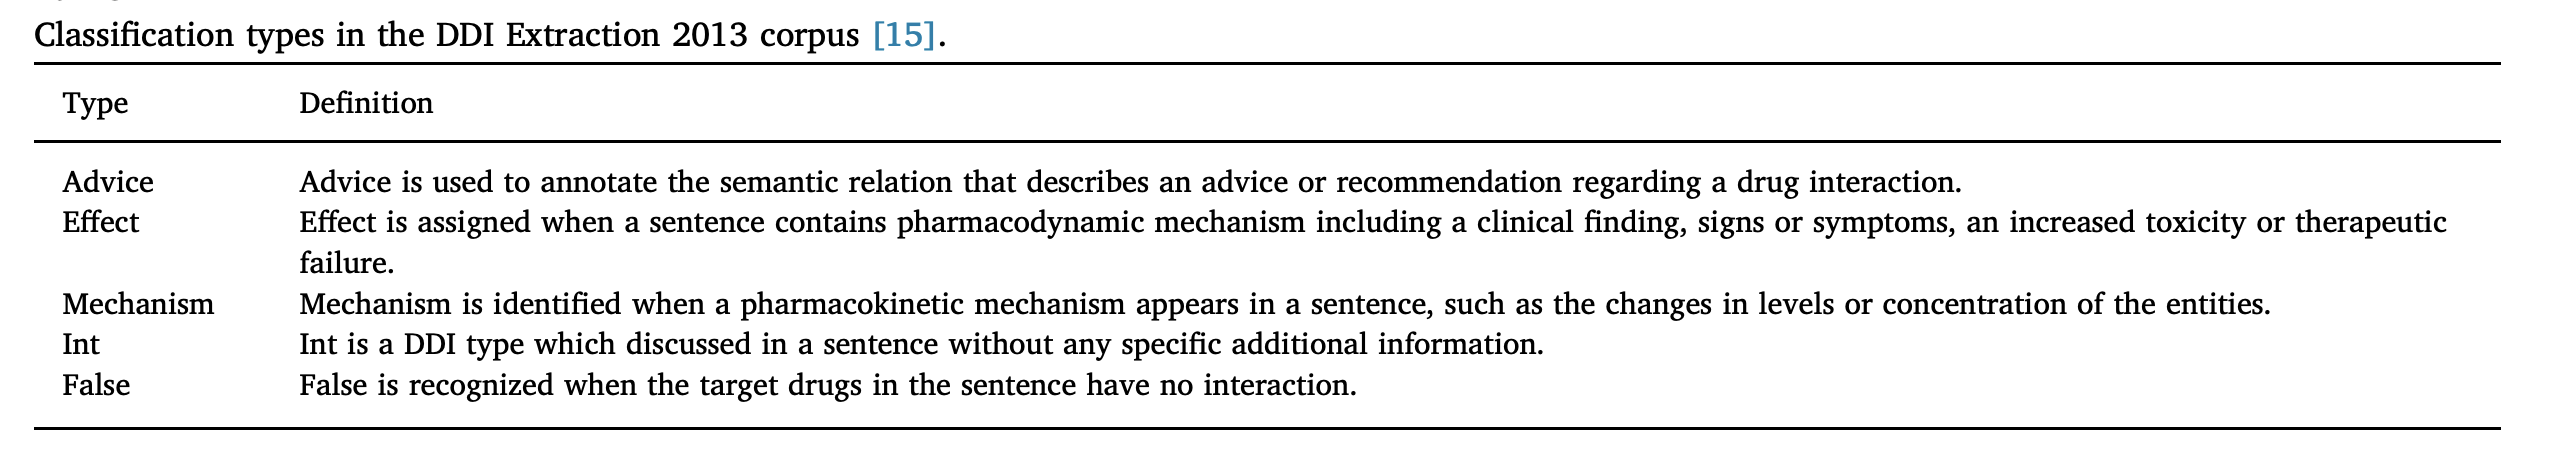

In [41]:

ner_tagger = NerDLModel()\
    .pretrained("ner_posology", "en", "clinical/models")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")   

ner_converter = NerConverterInternal() \
  .setInputCols(["sentences", "tokens", "ner_tags"]) \
  .setOutputCol("ner_chunk")

ddi_re_model = RelationExtractionModel()\
    .pretrained("re_drug_drug_interaction_clinical", "en", 'clinical/models')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunk", "dependencies"])\
    .setOutputCol("relations")\
    .setRelationPairs(["drug-drug"])\
    .setMaxSyntacticDistance(4)\

ddi_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    ner_tagger,
    ner_converter,
    dependency_parser,
    ddi_re_model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

ddi_model = ddi_pipeline.fit(empty_data)

loaded_lmodel = LightPipeline(ddi_model)

ner_posology download started this may take some time.
Approximate size to download 13.7 MB
[OK!]
re_drug_drug_interaction_clinical download started this may take some time.
Approximate size to download 4.6 MB
[OK!]


In [47]:
loaded_lmodel = LightPipeline(ddi_model)

text='When carbamazepine is withdrawn from the combination therapy, aripiprazole dose should then be reduced. \
If additional adrenergic drugs are to be administered by any route, \
they should be used with caution because the pharmacologically predictable sympathetic effects of Metformin may be potentiated'

annotations = loaded_lmodel.fullAnnotate(text)

rel_df = get_relations_df (annotations)


rel_df

,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
0,DDI-advise,DRUG,5,17,carbamazepine,DRUG,62,73,aripiprazole,0.99238014


In [48]:
annotations[0]['ner_chunk']

[Annotation(chunk, 5, 17, carbamazepine, {'entity': 'DRUG', 'sentence': '0', 'chunk': '0', 'confidence': '0.9968'}),
 Annotation(chunk, 62, 73, aripiprazole, {'entity': 'DRUG', 'sentence': '0', 'chunk': '1', 'confidence': '0.9998'}),
 Annotation(chunk, 118, 133, adrenergic drugs, {'entity': 'DRUG', 'sentence': '1', 'chunk': '2', 'confidence': '0.7984'}),
 Annotation(chunk, 270, 278, Metformin, {'entity': 'DRUG', 'sentence': '1', 'chunk': '3', 'confidence': '0.9998'})]

# Train a Relation Extraction Model

In [ ]:

data = spark.read.option("header","true").format("csv").load("i2b2_clinical_relfeatures.csv")

data = data.select( 'sentence','firstCharEnt1','firstCharEnt2','lastCharEnt1','lastCharEnt2', "chunk1", "chunk2", "label1", "label2",'rel','dataset')

data.show(10)

# you only need these columns>> 'sentence','firstCharEnt1','firstCharEnt2','lastCharEnt1','lastCharEnt2', "chunk1", "chunk2", "label1", "label2",'rel'
# ('dataset' column is optional)

+--------------------+-------------+-------------+------------+------------+--------------------+--------------------+---------+-------+-----+-------+
|            sentence|firstCharEnt1|firstCharEnt2|lastCharEnt1|lastCharEnt2|              chunk1|              chunk2|   label1| label2|  rel|dataset|
+--------------------+-------------+-------------+------------+------------+--------------------+--------------------+---------+-------+-----+-------+
|# BRBPR -- The pa...|            2|           60|           6|          77|               brbpr|  his lower gi bleed|  problem|problem|    O|   test|
|An angiography sh...|            1|           22|          14|          44|      an angiography|bleeding in two v...|     test|problem| TeRP|   test|
|His coumadin was ...|            1|           44|          12|          58|        his coumadin|     his acute bleed|treatment|problem|TrNAP|   test|
|- The patient und...|           24|           78|          43|         106|a flex sigmoidosco

In [ ]:
data.groupby('dataset').count().show()

+-------+-----+
|dataset|count|
+-------+-----+
|  train| 5489|
|   test|10721|
+-------+-----+



In [ ]:
#Annotation structure
annotationType = T.StructType([
            T.StructField('annotatorType', T.StringType(), False),
            T.StructField('begin', T.IntegerType(), False),
            T.StructField('end', T.IntegerType(), False),
            T.StructField('result', T.StringType(), False),
            T.StructField('metadata', T.MapType(T.StringType(), T.StringType()), False),
            T.StructField('embeddings', T.ArrayType(T.FloatType()), False)
        ])

#UDF function to convert train data to names entitities

@F.udf(T.ArrayType(annotationType))
def createTrainAnnotations(begin1, end1, begin2, end2, chunk1, chunk2, label1, label2):
    
    entity1 = sparknlp.annotation.Annotation("chunk", begin1, end1, chunk1, {'entity': label1.upper(), 'sentence': '0'}, [])
    entity2 = sparknlp.annotation.Annotation("chunk", begin2, end2, chunk2, {'entity': label2.upper(), 'sentence': '0'}, [])    
        
    entity1.annotatorType = "chunk"
    entity2.annotatorType = "chunk"

    return [entity1, entity2]    

#list of valid relations
rels = ["TrIP", "TrAP", "TeCP", "TrNAP", "TrCP", "PIP", "TrWP", "TeRP"]

#a query to select list of valid relations
valid_rel_query = "(" + " OR ".join(["rel = '{}'".format(rel) for rel in rels]) + ")"

data = data\
  .withColumn("begin1i", F.expr("cast(firstCharEnt1 AS Int)"))\
  .withColumn("end1i", F.expr("cast(lastCharEnt1 AS Int)"))\
  .withColumn("begin2i", F.expr("cast(firstCharEnt2 AS Int)"))\
  .withColumn("end2i", F.expr("cast(lastCharEnt2 AS Int)"))\
  .where("begin1i IS NOT NULL")\
  .where("end1i IS NOT NULL")\
  .where("begin2i IS NOT NULL")\
  .where("end2i IS NOT NULL")\
  .where(valid_rel_query)\
  .withColumn(
      "train_ner_chunks", 
      createTrainAnnotations(
          "begin1i", "end1i", "begin2i", "end2i", "chunk1", "chunk2", "label1", "label2"
      ).alias("train_ner_chunks", metadata={'annotatorType': "chunk"}))
    
data = data.filter(data.label1!='')
data = data.filter(data.label2!='')

train_data = data.where("dataset='train'")
test_data = data.where("dataset='test'")

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Healthcare/generic_classifier_graph/RE_in1200D_out20.pb

In [ ]:
documenter = sparknlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("sentences")

tokenizer = sparknlp.annotators.Tokenizer()\
    .setInputCols(["sentences"])\
    .setOutputCol("tokens")\

words_embedder = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", "en", "clinical/models")\
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("embeddings")

pos_tagger = PerceptronModel()\
    .pretrained("pos_clinical", "en", "clinical/models") \
    .setInputCols(["sentences", "tokens"])\
    .setOutputCol("pos_tags")
    
dependency_parser = sparknlp.annotators.DependencyParserModel()\
    .pretrained("dependency_conllu", "en")\
    .setInputCols(["sentences", "pos_tags", "tokens"])\
    .setOutputCol("dependencies")

# set training params and upload model graph (see ../Healthcare/8.Generic_Classifier.ipynb)
reApproach = sparknlp_jsl.annotator.RelationExtractionApproach()\
    .setInputCols(["embeddings", "pos_tags", "train_ner_chunks", "dependencies"])\
    .setOutputCol("relations")\
    .setLabelColumn("rel")\
    .setEpochsNumber(50)\
    .setBatchSize(200)\
    .setDropout(0.5)\
    .setLearningRate(0.001)\
    .setModelFile("/content/RE_in1200D_out20.pb")\
    .setFixImbalance(True)\
    .setFromEntity("begin1i", "end1i", "label1")\
    .setToEntity("begin2i", "end2i", "label2")\
    .setOutputLogsPath('/content')

finisher = sparknlp.Finisher()\
    .setInputCols(["relations"])\
    .setOutputCols(["relations_out"])\
    .setCleanAnnotations(False)\
    .setValueSplitSymbol(",")\
    .setAnnotationSplitSymbol(",")\
    .setOutputAsArray(False)

train_pipeline = Pipeline(stages=[
    documenter, tokenizer, words_embedder, pos_tagger, 
    dependency_parser, reApproach, finisher
])

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
pos_clinical download started this may take some time.
Approximate size to download 1.7 MB
[OK!]
dependency_conllu download started this may take some time.
Approximate size to download 16.6 MB
[OK!]


In [ ]:
%time rel_model = train_pipeline.fit(train_data)

CPU times: user 177 ms, sys: 35.2 ms, total: 212 ms
Wall time: 14min 24s


In [ ]:
rel_model.stages[-2]

RelationExtractionModel_07995696a2d4

In [ ]:
rel_model.stages[-2].write().overwrite().save('custom_RE_model')

In [ ]:
result = rel_model.transform(test_data)

In [ ]:
recall = result\
  .groupBy("rel")\
  .agg(F.avg(F.expr("IF(rel = relations_out, 1, 0)")).alias("recall"))\
  .select(
      F.col("rel").alias("relation"), 
      F.format_number("recall", 2).alias("recall"))\
  .show()

performance  = result\
  .where("relations_out <> ''")\
  .groupBy("relations_out")\
  .agg(F.avg(F.expr("IF(rel = relations_out, 1, 0)")).alias("precision"))\
  .select(
      F.col("relations_out").alias("relation"), 
      F.format_number("precision", 2).alias("precision"))\
  .show()

+--------+------+
|relation|recall|
+--------+------+
|    TrIP|  0.20|
|    TrAP|  0.93|
|    TeCP|  0.53|
|   TrNAP|  0.14|
|    TrCP|  0.50|
|     PIP|  0.96|
|    TrWP|  0.03|
|    TeRP|  0.92|
+--------+------+

+--------+---------+
|relation|precision|
+--------+---------+
|    TrIP|     0.61|
|    TrAP|     0.79|
|    TeCP|     0.59|
|   TrNAP|     0.41|
|    TrCP|     0.62|
|     PIP|     0.98|
|    TrWP|     0.18|
|    TeRP|     0.90|
+--------+---------+



In [ ]:
result_df = result.select(F.explode(F.arrays_zip('relations.result', 'relations.metadata')).alias("cols")) \
.select(F.expr("cols['0']").alias("relation"),
        F.expr("cols['1']['entity1']").alias("entity1"),
        F.expr("cols['1']['entity1_begin']").alias("entity1_begin"),
        F.expr("cols['1']['entity1_end']").alias("entity1_end"),
        F.expr("cols['1']['chunk1']").alias("chunk1"),
        F.expr("cols['1']['entity2']").alias("entity2"),
        F.expr("cols['1']['entity2_begin']").alias("entity2_begin"),
        F.expr("cols['1']['entity2_end']").alias("entity2_end"),
        F.expr("cols['1']['chunk2']").alias("chunk2"),
        F.expr("cols['1']['confidence']").alias("confidence")
        )

result_df.show(50, truncate=100)



## Load trained model from disk

In [ ]:
import pandas as pd

def get_relations_df (results, col='relations'):
  rel_pairs=[]
  for rel in results[0][col]:
      rel_pairs.append((
          rel.result, 
          rel.metadata['entity1'], 
          rel.metadata['entity1_begin'],
          rel.metadata['entity1_end'],
          rel.metadata['chunk1'], 
          rel.metadata['entity2'],
          rel.metadata['entity2_begin'],
          rel.metadata['entity2_end'],
          rel.metadata['chunk2'], 
          rel.metadata['confidence']
      ))

  rel_df = pd.DataFrame(rel_pairs, columns=['relation','entity1','entity1_begin','entity1_end','chunk1','entity2','entity2_begin','entity2_end','chunk2', 'confidence'])

  return rel_df

In [ ]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencer = SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentences")

clinical_ner_tagger = sparknlp.annotators.NerDLModel()\
    .load("ner_clinical")\
    .setInputCols("sentences", "tokens", "embeddings")\
    .setOutputCol("ner_tags")    

loaded_re_Model = RelationExtractionModel()\
    .load("custom_RE_model')\
    .setInputCols(["embeddings", "pos_tags", "ner_chunks", "dependencies"]) \
    .setOutputCol("relations")\
    .setRelationPairs(["problem-test", "problem-treatment"])\
    .setPredictionThreshold(0.9)\
    .setMaxSyntacticDistance(4)

trained_pipeline = Pipeline(stages=[
    documenter,
    sentencer,
    tokenizer, 
    words_embedder, 
    pos_tagger, 
    clinical_ner_tagger,
    ner_chunker,
    dependency_parser,
    loaded_re_Model
])

empty_data = spark.createDataFrame([[""]]).toDF("text")

loaded_re_model = trained_pipeline.fit(empty_data)


text ="""A 28-year-old female with a history of gestational diabetes mellitus diagnosed eight years prior to presentation and subsequent type two diabetes mellitus ( T2DM ), 
one prior episode of HTG-induced pancreatitis three years prior to presentation,  associated with an acute hepatitis , and obesity with a body mass index ( BMI ) of 33.5 kg/m2 , presented with a one-week history of polyuria , polydipsia , poor appetite , and vomiting . Two weeks prior to presentation , she was treated with a five-day course of amoxicillin for a respiratory tract infection . She was on metformin , glipizide , and dapagliflozin for T2DM and atorvastatin and gemfibrozil for HTG . She had been on dapagliflozin for six months at the time of presentation. Physical examination on presentation was significant for dry oral mucosa ; significantly , her abdominal examination was benign with no tenderness , guarding , or rigidity . Pertinent laboratory findings on admission were : serum glucose 111 mg/dl , bicarbonate 18 mmol/l , anion gap 20 , creatinine 0.4 mg/dL , triglycerides 508 mg/dL , total cholesterol 122 mg/dL , glycated hemoglobin ( HbA1c ) 10% , and venous pH 7.27 . Serum lipase was normal at 43 U/L . Serum acetone levels could not be assessed as blood samples kept hemolyzing due to significant lipemia . The patient was initially admitted for starvation ketosis , as she reported poor oral intake for three days prior to admission . However , serum chemistry obtained six hours after presentation revealed her glucose was 186 mg/dL , the anion gap was still elevated at 21 , serum bicarbonate was 16 mmol/L , triglyceride level peaked at 2050 mg/dL , and lipase was 52 U/L . The β-hydroxybutyrate level was obtained and found to be elevated at 5.29 mmol/L - the original sample was centrifuged and the chylomicron layer removed prior to analysis due to interference from turbidity caused by lipemia again . The patient was treated with an insulin drip for euDKA and HTG with a reduction in the anion gap to 13 and triglycerides to 1400 mg/dL , within 24 hours . Her euDKA was thought to be precipitated by her respiratory tract infection in the setting of SGLT2 inhibitor use . The patient was seen by the endocrinology service and she was discharged on 40 units of insulin glargine at night , 12 units of insulin lispro with meals , and metformin 1000 mg two times a day . It was determined that all SGLT2 inhibitors should be discontinued indefinitely . 
She had close follow-up with endocrinology post discharge .
"""

loaded_re_model_light = LightPipeline(loaded_re_model)

annotations = loaded_re_model_light.fullAnnotate(text)

rel_df = get_relations_df (annotations)

rel_df[rel_df.relation!="O"]


re_clinical download started this may take some time.
Approximate size to download 6 MB
[OK!]


,relation,entity1,entity1_begin,entity1_end,chunk1,entity2,entity2_begin,entity2_end,chunk2,confidence
6,TrAP,PROBLEM,617,620,T2DM,TREATMENT,626,637,atorvastatin,0.99955326
12,TrWP,TEST,1246,1258,blood samples,PROBLEM,1283,1301,significant lipemia,0.99998724
16,TeRP,TEST,1535,1547,the anion gap,PROBLEM,1553,1566,still elevated,0.9965193
22,TrAP,TEST,1838,1845,analysis,PROBLEM,1854,1880,interference from turbidity,0.9676019
26,TrWP,TREATMENT,1937,1951,an insulin drip,PROBLEM,1976,2003,a reduction in the anion gap,0.94099987
28,TeRP,PROBLEM,1976,2003,a reduction in the anion gap,TEST,2015,2027,triglycerides,0.9956793
29,TeRP,PROBLEM,2107,2137,her respiratory tract infection,TREATMENT,2157,2171,SGLT2 inhibitor,0.997498
